In [7]:
#!/usr/bin/env python3
"""
Ejemplo de script organizado en funciones para:
1. Crear un dominio 2D (X_domain, Y_domain).
2. Crear y ubicar una "bahía" como sólido de revolución.
3. Ajustar pendiente (slope) y aplicar un suavizado (gaussian_filter).
4. Guardar el resultado final en un archivo NetCDF.
5. Visualizaciones de control.

Requisitos:
- numpy
- matplotlib
- scipy (griddata, gaussian_filter)
- netCDF4
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter
import netCDF4 as nc

# ------------------------------
#   1. Generación de dominios
# ------------------------------
def generar_dominios(L_expansion, DelX, x_min_expand, x_max_expand,
                     y_min, y_max, ny_expand):
    """
    Genera los vectores x_domain y y_domain, combinando una región central
    de ancho ±L_expansion y expansiones cuadráticas en los extremos.
    También crea un dominio Y con parte expandida.
    """
    # PARTE X
    # Vector central (entre ±L_expansion) con espaciado uniforme DelX
    nx_center = int(2 * L_expansion / DelX)  # num. de puntos en la parte central
    x_center = np.linspace(-L_expansion, L_expansion, nx_center)

    # Expansión cuadrática a derecha e izquierda
    k = DelX
    # Determinamos número de puntos para expansión en X
    # (valor elegido de modo que llegue cerca de x_max_expand)
    i_values_x = np.arange(56)  # <--- ajustado manualmente en tu ejemplo
    x_right = x_center[-1] + k * i_values_x**2
    x_left = -np.flip(x_right)

    # Quitamos solapamientos con la parte central
    x_left = x_left[:-1]
    x_right = x_right[1:]

    # Unimos todo
    x_domain = np.concatenate((x_left, x_center, x_right))

    # PARTE Y
    # Expansión cuadrática
    i_values_y = np.arange(ny_expand + 1)
    y_expand = y_min - (k * i_values_y**2)
    y_expand = np.flip(y_expand)
    y_expand = y_expand[:-1]

    # Parte central en Y (uniforme)
    ny_center = int((y_max - y_min) / DelX)  # en tu caso usabas DelY diferente, ajústalo
    y_center = np.linspace(y_min, y_max, ny_center)

    y_domain = np.concatenate((y_expand, y_center))

    return x_domain, y_domain


def construir_malla_2D(x_domain, y_domain):
    """
    A partir de los vectores x_domain e y_domain, crea una malla 2D (X_domain, Y_domain)
    y un Z_domain inicial (inicializado en ceros).
    """
    X_domain, Y_domain = np.meshgrid(x_domain, y_domain)
    Z_domain = np.zeros_like(X_domain)
    return X_domain, Y_domain, Z_domain


# ------------------------------
# 2. Construcción de la "bahía"
# ------------------------------
def construir_bahia(L_FIJADO, DelX, DelY):
    """
    Construye la bahía como un sólido de revolución definido por la función h(r) = h1 * (1 - (r^2 / L_FIJADO^2)).
    Crea una malla (X_new, Y_new) y la altimetría Z_bahia (negativa, profundidad).
    """
    # Parámetros de la bahía
    h1 = 164  # profundidad en el centro
    nr = int(L_FIJADO / DelY)  # resolución radial

    r = np.linspace(0, L_FIJADO, nr)  # eje radial
    theta = np.linspace(0, np.pi, 400)  # ángulo para el semicírculo

    # Creamos la malla en coordenadas polares
    R, Theta = np.meshgrid(r, theta)

    # Definición de la función de profundidad
    h_r = h1 * (1 - (R**2) / (L_FIJADO**2))  # variable radial

    # Convertir a cartesianas
    X_bahia = R * np.cos(Theta)
    Y_bahia = R * np.sin(Theta)
    Z_bahia_polar = h_r  # sin el negativo aún

    # Definimos una malla final para la bahía (cartesiana)
    x_new = np.linspace(X_bahia.min(), X_bahia.max(), int(2 * L_FIJADO / DelX))
    y_new = np.linspace(Y_bahia.min(), Y_bahia.max(), int(L_FIJADO / DelY))
    X_new, Y_new = np.meshgrid(x_new, y_new)

    # Interpolación en la malla cartesiana
    points = np.column_stack((X_bahia.flatten(), Y_bahia.flatten()))
    values = Z_bahia_polar.flatten()
    Z_bahia = griddata(points, values, (X_new, Y_new), method='linear')
    Z_bahia = np.nan_to_num(Z_bahia, nan=0)

    # Lo volvemos negativo (batimetría)
    Z_bahia = -Z_bahia

    return X_new, Y_new, Z_bahia


def insertar_bahia_en_dominio(X_domain, Y_domain, Z_domain,
                              X_new, Y_new, Z_bahia,
                              L_FIJADO, DelX, Y_fondo, Fondo_lineal,
                              ny_expand):
    """
    Inserta la bahía (X_new, Y_new, Z_bahia) en la malla grande (X_domain, Y_domain, Z_domain).
    Se asume que se ubica en un rango de índices calculados a partir de:
      - centro en X
      - offset en Y (ny_expand + algo)
    """
    # Hallar centro en X
    X_idx_half = int(len(X_domain[0]) / 2)
    # Extremos en X para la bahía
    X_idx_start_bahia = int(X_idx_half - int(L_FIJADO / DelX))
    X_idx_end_bahia = X_idx_start_bahia + Z_bahia.shape[1]

    # Índices en Y
    Idx_bahia_start = ny_expand + int(abs(Y_fondo + Fondo_lineal) / DelX) - 1
    Y_idx_end_bahia = Idx_bahia_start + Z_bahia.shape[0]

    # Insertamos la bahía
    Z_domain[Idx_bahia_start:Y_idx_end_bahia, X_idx_start_bahia:X_idx_end_bahia] = Z_bahia

    return Z_domain


# ------------------------------
# 3. Pendiente y suavizado
# ------------------------------
def agregar_pendiente_y_suavizar(Z_domain, Z_max, h1,
                                 Idx_slope_start, Idx_bahia_start,
                                 sigma=5, max_depth=-600):
    """
    Añade una pendiente lineal en la zona entre Idx_slope_start y Idx_bahia_start.
    Aplica suavizado Gaussiano con sigma, y recorta a max_depth.
    """
    # Llenar la parte superior con un valor fijo (por ejemplo -1000)
    Z_domain[:Idx_slope_start+1, :] = -1000

    # Pendiente lineal entre Z_max y -h1
    Y_slope = np.linspace(Z_max, -h1, (Idx_bahia_start + 1 - Idx_slope_start))
    for i, val in enumerate(Y_slope):
        row_idx = Idx_slope_start + i
        Z_domain[row_idx, :] = val

    # Suavizado Gaussiano
    Z_smooth = gaussian_filter(Z_domain, sigma=sigma)

    # Recorte de profundidad
    Z_final = np.where(Z_smooth >= max_depth, Z_smooth, max_depth)

    return Z_final


# ------------------------------
# 4. Visualización
# ------------------------------
def plot_3d_surface(X, Y, Z, title="Superficie 3D"):
    """
    Grafica la superficie 3D usando plot_surface.
    """
    from mpl_toolkits.mplot3d import Axes3D  # noqa
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis')
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    ax.set_zlabel("Z (m)")
    ax.set_title(title)
    plt.show()


def plot_2d_contours(X, Y, Z, levels=33, title="Contornos 2D"):
    """
    Grafica contornos 2D para revisar la batimetría.
    """
    plt.figure(figsize=(8, 6))
    cs = plt.contourf(X, Y, Z, levels, cmap='viridis')
    plt.colorbar(cs)
    plt.contour(X, Y, -Z, levels=np.arange(0, 1600, 50), colors='k')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title(title)
    plt.xlabel("X (m)")
    plt.ylabel("Y (m)")
    plt.show()

def plot_2d_contours_with_zoom(X, Y, Z,
                               idx_slope_start,
                               x_idx_start_bahia,
                               x_idx_end,
                               levels=33,
                               title="Contornos 2D",
                               title_zoom="Zoom Bahía"):
    """
    Grafica contornos 2D en dos subplots:
      - Subplot 1: Vista completa del dominio.
      - Subplot 2: Zoom (subsección) en la región de la bahía, usando los índices indicados.

    Parámetros
    ----------
    X, Y, Z : numpy arrays 2D
        Mallas 2D (X, Y) y campo scalar Z (p. ej., batimetría).
    idx_slope_start : int
        Índice inicial en Y a partir del cual hacer zoom (ej. Idx_slope_start).
    x_idx_start_bahia : int
        Índice inicial en X para la bahía.
    x_idx_end : int
        Índice final en X para la bahía.
    levels : int
        Número de niveles para contourf.
    title : str
        Título del subplot general.
    title_zoom : str
        Título del subplot con el zoom.
    """

    # Creamos la figura con 2 subplots horizontales
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # === Subplot 1: Vista global del dominio ===
    cs = ax1.contourf(X, Y, Z, levels, cmap='viridis')
    # Para que la escala de colores aparezca en ax1:
    fig.colorbar(cs, ax=ax1, label="Profundidad (m)")

    # Contornos de líneas cada 50 m (por ejemplo)
    ax1.contour(X, Y, -Z, levels=np.arange(0, 1600, 50), colors='k')
    ax1.set_aspect('equal')
    ax1.set_title(title)
    ax1.set_xlabel("X (m)")
    ax1.set_ylabel("Y (m)")

    # === Subplot 2: Zoom de la bahía ===
    # Cortamos en filas a partir de idx_slope_start: (Y) y columnas x_idx_start_bahia:x_idx_end (X)
    cs2 = ax2.contourf(X[idx_slope_start:, x_idx_start_bahia:x_idx_end],
                       Y[idx_slope_start:, x_idx_start_bahia:x_idx_end],
                       Z[idx_slope_start:, x_idx_start_bahia:x_idx_end],
                       levels, cmap='viridis')
    # Solo a modo ilustrativo, podrías poner su propio colorbar si lo deseas:
    # fig.colorbar(cs2, ax=ax2)

    ax2.contour(X[idx_slope_start:, x_idx_start_bahia:x_idx_end],
                Y[idx_slope_start:, x_idx_start_bahia:x_idx_end],
                -Z[idx_slope_start:, x_idx_start_bahia:x_idx_end],
                levels=np.arange(0, 600, 50), colors='k')

    ax2.set_aspect('equal')
    ax2.set_title(title_zoom)
    ax2.set_xlabel("X (m)")
    ax2.set_ylabel("Y (m)")

    plt.tight_layout()
    plt.show()



# ------------------------------
# 5. Guardar a NetCDF
# ------------------------------
def guardar_netcdf(filename, X, Y, Z, Z_smooth):
    """
    Crea un archivo NetCDF (filename) y guarda X, Y, Z y Z_smooth.
    """
    with nc.Dataset(filename, 'w', format='NETCDF4') as ds:
        ny, nx = Z.shape

        ds.createDimension('x', nx)
        ds.createDimension('y', ny)

        x_var = ds.createVariable('X', np.float32, ('y', 'x'))
        y_var = ds.createVariable('Y', np.float32, ('y', 'x'))
        z_var = ds.createVariable('Z', np.float32, ('y', 'x'))
        z_smooth_var = ds.createVariable('Z_sm', np.float32, ('y', 'x'))

        x_var.units = 'meters'
        y_var.units = 'meters'
        z_var.units = 'meters'
        z_smooth_var.units = 'meters'

        x_var.description = 'Coordenadas X del dominio'
        y_var.description = 'Coordenadas Y del dominio'
        z_var.description = 'Datos de profundidad del dominio Z'
        z_smooth_var.description = 'Datos suavizados de profundidad del dominio Z'

        x_var[:, :] = X
        y_var[:, :] = Y
        z_var[:, :] = Z
        z_smooth_var[:, :] = Z_smooth

    print(f"Datos guardados exitosamente en {filename}")


# ------------------------------
# 6. Función principal
# ------------------------------
def main():
    # Parámetros generales
    h1 = 164
    L = 119000
    L_FIJADO = 11900
    Z_max = -1493 - 164  # Profundidad en Y = -62000
    Y_fondo = -62000
    Fondo_lineal = -440000
    Costa_extra = 20000
    L_expansion = 2 * L
    DelX = 200
    DelY = 200
    ny_expand = 30

    # Generar dominios X, Y
    x_min_expand = -800e3
    x_max_expand = 800e3
    y_min = -int(abs(Y_fondo) + 440000)
    y_max = int(L + Costa_extra + 800)
    x_domain, y_domain = generar_dominios(L_expansion, DelX, x_min_expand, x_max_expand,
                                          y_min, y_max, ny_expand)
    # Construir malla
    X_domain, Y_domain, Z_domain = construir_malla_2D(x_domain, y_domain)

    # Construir la bahía como sólido de revolución
    X_new, Y_new, Z_bahia = construir_bahia(L_FIJADO, DelX, DelY)

    # Insertar la bahía en el dominio
    Z_domain = insertar_bahia_en_dominio(X_domain, Y_domain, Z_domain,
                                         X_new, Y_new, Z_bahia,
                                         L_FIJADO, DelX, Y_fondo, Fondo_lineal,
                                         ny_expand)

    # Definir índices para pendiente
    # (estos valores fueron calculados experimentalmente en tu código original)
    Idx_slope_start = ny_expand + int(abs(Fondo_lineal) / DelY) - 1
    Idx_bahia_start = ny_expand + int(abs(Y_fondo + Fondo_lineal) / DelY) - 1

    # Agregar pendiente y suavizar
    Z_final = agregar_pendiente_y_suavizar(Z_domain, Z_max, h1,
                                           Idx_slope_start, Idx_bahia_start,
                                           sigma=5, max_depth=-600)

    # Hacer un suavizado adicional si se desea
    Z_smooth = gaussian_filter(Z_final, sigma=15)

    # Visualizaciones de ejemplo
    plot_3d_surface(X_domain, Y_domain, Z_final, title="Dominio 3D - Versión Final")
    plot_2d_contours(X_domain, Y_domain, Z_smooth, title="Contornos Suavizados")


    # Guardar en NetCDF
    filename = 'bahia01_expand_bat.nc'
    guardar_netcdf(filename, X_domain, Y_domain, Z_final, Z_smooth)

    print("Fin de la ejecución del script.")


#if __name__ == "__main__":
#    main()


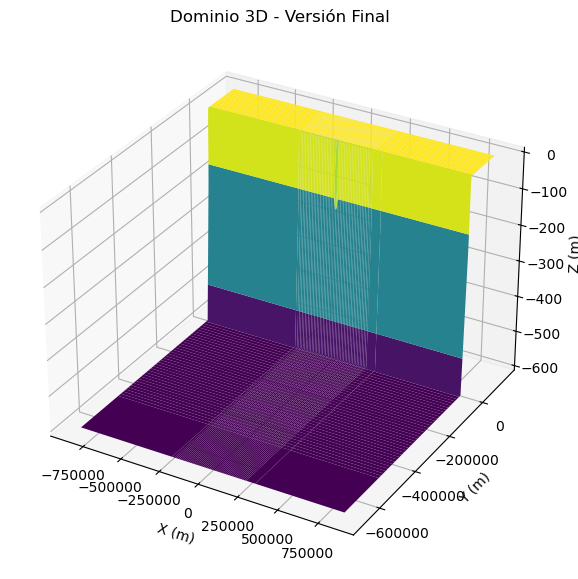

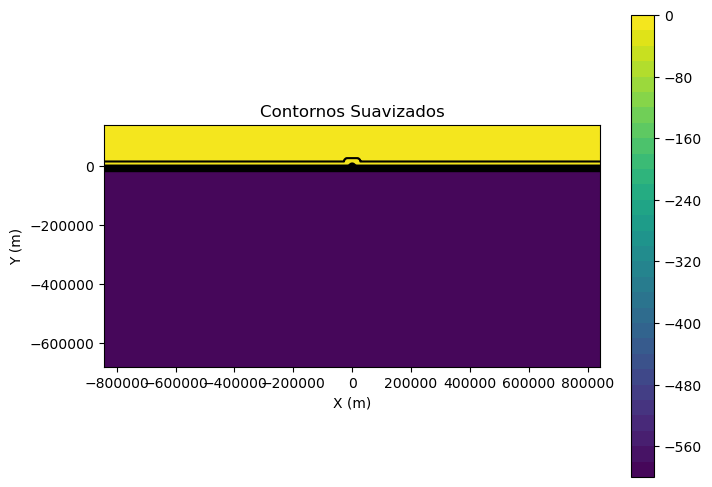

Datos guardados exitosamente en bahia01_expand_bat.nc
Fin de la ejecución del script.


In [8]:
main()

In [9]:
# ------------------------------
# 6. Función principal
# ------------------------------
def main_nobay():
    # Parámetros generales
    h1 = 164
    L = 119000
    L_FIJADO = 11900
    Z_max = -1493 - 164  # Profundidad en Y = -62000
    Y_fondo = -62000
    Fondo_lineal = -440000
    Costa_extra = 20000
    L_expansion = 2 * L
    DelX = 200
    DelY = 200
    ny_expand = 30

    # Generar dominios X, Y
    x_min_expand = -800e3
    x_max_expand = 800e3
    y_min = -int(abs(Y_fondo) + 440000)
    y_max = int(L + Costa_extra + 800)
    x_domain, y_domain = generar_dominios(L_expansion, DelX, x_min_expand, x_max_expand,
                                          y_min, y_max, ny_expand)
    # Construir malla
    X_domain, Y_domain, Z_domain = construir_malla_2D(x_domain, y_domain)

    # Construir la bahía como sólido de revolución
    #X_new, Y_new, Z_bahia = construir_bahia(L_FIJADO, DelX, DelY)

    # Insertar la bahía en el dominio
    #Z_domain = insertar_bahia_en_dominio(X_domain, Y_domain, Z_domain,
    #                                     X_new, Y_new, Z_bahia,
    #                                     L_FIJADO, DelX, Y_fondo, Fondo_lineal,
    #                                     ny_expand)

    # Definir índices para pendiente
    # (estos valores fueron calculados experimentalmente en tu código original)
    Idx_slope_start = ny_expand + int(abs(Fondo_lineal) / DelY) - 1
    Idx_bahia_start = ny_expand + int(abs(Y_fondo + Fondo_lineal) / DelY) - 1

    # Agregar pendiente y suavizar
    Z_final = agregar_pendiente_y_suavizar(Z_domain, Z_max, h1,
                                           Idx_slope_start, Idx_bahia_start,
                                           sigma=5, max_depth=-600)

    # Hacer un suavizado adicional si se desea
    Z_smooth = gaussian_filter(Z_final, sigma=15)

    # Visualizaciones de ejemplo
    plot_3d_surface(X_domain, Y_domain, Z_final, title="Dominio 3D - Versión Final")
    plot_2d_contours(X_domain, Y_domain, Z_smooth, title="Contornos Suavizados")


    # Guardar en NetCDF
    filename = 'bahia01_expand_noBay.nc'
    guardar_netcdf(filename, X_domain, Y_domain, Z_final, Z_smooth)

    print("Fin de la ejecución del script.")

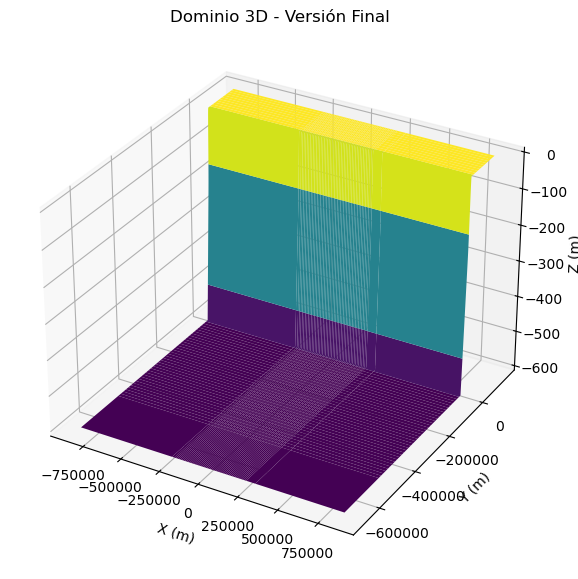

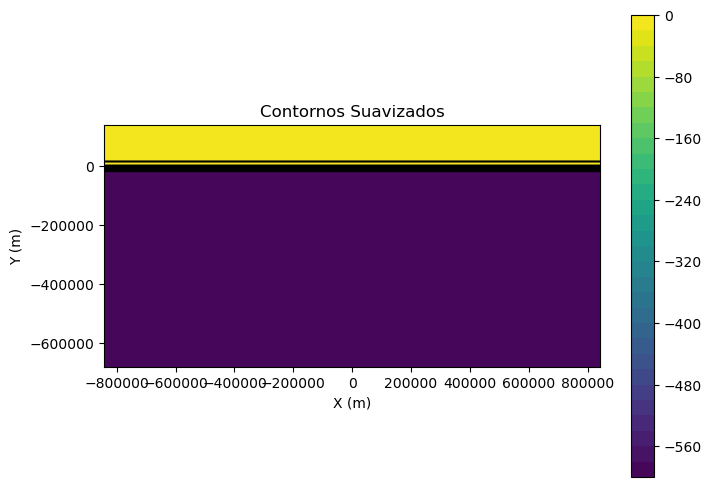

Datos guardados exitosamente en bahia01_expand_noBay.nc
Fin de la ejecución del script.


In [10]:
main_nobay()

Dimensiones originales:
  Xog=(3239, 2490), Yog=(3239, 2490), Zog=(3239, 2490)
Rangos:
  X min=-843000.0 m, X max=843000.0 m
  Y min=-682000.0 m, Y max=139800.0 m


/var/folders/md/v_9w0p656250q6gw5wc707040000gn/T/ipykernel_3604/3887039228.py:89: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f_interp = sci_interp.interp2d(Xog[0, :], Yog[:, 0], Zog)
/var/folders/md/v_9w0p656250q6gw5wc707040000gn/T/ipykernel_3604/3887039228.py:92: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular gr

bathy.shape antes del recorte = (1100, 366)
y_vect.shape antes del recorte = (1100,)
x_vect.shape antes del recorte = (366,)
bathy.shape después del recorte = (496, 352)
x_vect.shape=(352,), y_vect.shape=(496,)


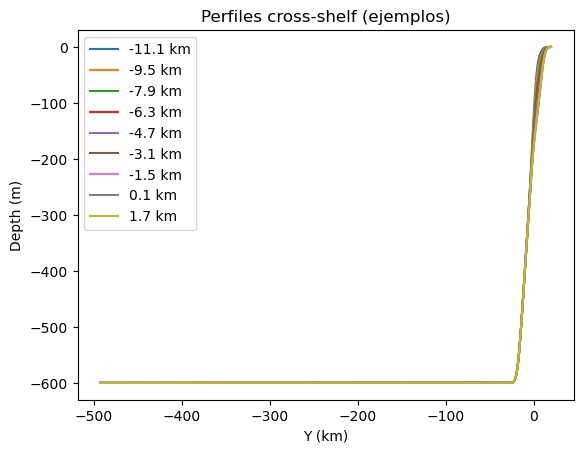

dx (muestra): [22600. 22200. 21800. 21400. 21000. 20600. 20200. 19800. 19400. 19000.] ...
dy (muestra): [18200. 17800. 17400. 17000. 16600. 16200. 15800. 15400. 15000. 14600.] ...
Archivos guardados:
  bahia_01_expand_bat.bin
  bahia_01_expand_dx.bin
  bahia_01_expand_dy.bin


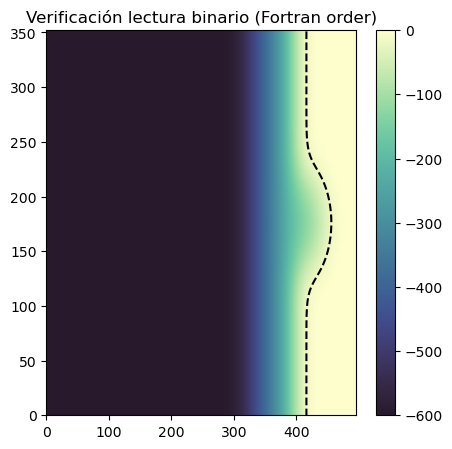

Finalizó la generación de archivos binarios para MITgcm.


In [ ]:
# ------------------------------------------------
#  Script para MITgcm: Interpolación, recorte y binarios
# ------------------------------------------------
"""
Script para:
1) Leer un NetCDF de batimetría (X, Y, Z).
2) Definir nueva malla expandida en X e Y.
3) Interpolar Z a la nueva malla.
4) Recortar filas/columnas para ajustar dimensiones finales.
5) Crear y guardar binarios de batimetría y grid spacing (dx, dy) para MITgcm.
"""

import numpy as np
import matplotlib.pyplot as plt
import cmocean as cmo
from netCDF4 import Dataset
import scipy.interpolate as sci_interp

def mainbin():
    # ------------------------------------------------
    # 1. Parámetros y archivo de entrada
    # ------------------------------------------------
    nc_file = 'bahia01_expand_bat.nc'  # Nombre del archivo netCDF con la bathy original
    bathy_fname = 'bahia_01_expand_bat.bin'
    dx_fname = 'bahia_01_expand_dx.bin'
    dy_fname = 'bahia_01_expand_dy.bin'
    endian_dtype = np.dtype('>f8')  # Float64 big-endian (usado por MITgcm)

    # ------------------------------------------------
    # 2. Lectura de la batimetría original (netCDF)
    # ------------------------------------------------
    with Dataset(nc_file, 'r') as nbl:
        Xog = nbl.variables['X'][:]
        Yog = nbl.variables['Y'][:]
        Zog = nbl.variables['Z_sm'][:]

    print(f"Dimensiones originales:\n  Xog={Xog.shape}, Yog={Yog.shape}, Zog={Zog.shape}")
    print(f"Rangos:\n  X min={Xog.min():.1f} m, X max={Xog.max():.1f} m\n"
          f"  Y min={Yog.min():.1f} m, Y max={Yog.max():.1f} m")

    # ------------------------------------------------
    # 3. Definición de la nueva malla
    #    (x_vect, y_vect) con expansión cuadrática
    # ------------------------------------------------
    # Valores centrales, expansión y límites
    nx_center = 238   # Número de puntos en la región central (X)
    ny_center = 1045  # Número de puntos en la región central (Y)

    # Anchura central de X (± x_max_center)
    # Se asume un Δx ~ 200 m => total de 238*200 = 47600 m a cada lado
    DeltaX = 200
    x_max_center = DeltaX * nx_center / 2   # ~ 23800
    x_min_center = -x_max_center

    # Expansión exterior
    x_min_expand = -843e3
    x_max_expand =  843e3

    # Para Y
    DeltaY = 200
    y_min = -62e3 - 8e3   # -70000
    y_max = 139e3         # 139000
    ny_span = ny_center
    y_min_expand = -682000

    # Creamos el centro
    x_center = np.linspace(x_min_center, x_max_center, nx_center)
    y_center = np.linspace(y_min, y_max, ny_span)

    # Expansión cuadrática
    k = DeltaX
    # Eje X
    i_values = np.arange(1, int(np.sqrt((x_max_expand - x_max_center) / k)) + 1)
    x_right = x_max_center + k * i_values**2
    x_left  = -np.flip(x_right)

    # Eje Y
    i_values_y = np.arange(1, int(np.sqrt((abs(y_min_expand) - abs(y_min)) / k)) + 1)
    y_expand   = y_min - (k * i_values_y**2)
    y_expand   = np.flip(y_expand)

    # Concatenar
    x_vect = np.concatenate((x_left, x_center, x_right))
    y_vect = np.concatenate((y_expand, y_center))

    # ------------------------------------------------
    # 4. Interpolación
    # ------------------------------------------------
    # Usando interp2d (en desuso, pero se mantiene por compatibilidad)
    # Podrías usar griddata o RegularGridInterpolator si lo prefieres.
    f_interp = sci_interp.interp2d(Xog[0, :], Yog[:, 0], Zog)

    # Interpolar la batimetría a la nueva malla
    bathy = f_interp(x_vect, y_vect)

    print(f"bathy.shape antes del recorte = {bathy.shape}")
    print(f"y_vect.shape antes del recorte = {y_vect.shape}")
    print(f"x_vect.shape antes del recorte = {x_vect.shape}")

    # ------------------------------------------------
    # 5. Recortes (ej. filtrar Y < 20, etc.)
    # ------------------------------------------------
    mask_Ydomain = (y_vect < 20000)
    bathy_sub = bathy[mask_Ydomain, :]
    y_sub     = y_vect[mask_Ydomain]

    # Asignamos a variables principales
    bathy = bathy_sub
    y_vect = y_sub

    # Recorte simétrico en columnas (ej. quitar 7 a la izq y 7 a la der)
    bathy = bathy[:, 7:-7]
    x_vect = x_vect[7:-7]

    # Recorte de filas (ej. quitar 9 filas iniciales)
    bathy = bathy[9:, :]
    y_vect = y_vect[9:]

    print(f"bathy.shape después del recorte = {bathy.shape}")
    print(f"x_vect.shape={x_vect.shape}, y_vect.shape={y_vect.shape}")

    # ------------------------------------------------
    # 6. Visualización de control
    # ------------------------------------------------
    fig, ax = plt.subplots(figsize=(9, 7))
    pc = ax.pcolormesh(x_vect/1000, y_vect/1000, bathy, cmap=cmo.cm.deep_r)
    cb = plt.colorbar(pc)
    cb.set_label('Profundidad (m)')

    # Contornos: ejemplo a 250 m y 0 m
    ax.contour(x_vect/1000, y_vect/1000, -bathy, colors='0.5', levels=[250])
    ax.contour(x_vect/1000, y_vect/1000, -bathy, colors='k', levels=[0])

    ax.set_aspect('equal')
    ax.set_xlabel('X (km)')
    ax.set_ylabel('Y (km)')
    plt.title("Dom. Interpolado Recortado")
    plt.savefig("dominio_bath.png", dpi=300)
    plt.close()

    # Ejemplo de varios perfiles cross-shelf
    for ii in range(120, 186, 8):
        plt.plot(y_vect/1e3, bathy[:, ii], label=f'{x_vect[ii]/1e3:.1f} km')
    plt.legend()
    plt.xlabel('Y (km)')
    plt.ylabel('Depth (m)')
    plt.title("Perfiles cross-shelf (ejemplos)")
    plt.show()

    # ------------------------------------------------
    # 7. Construir dx, dy y guardar binarios
    # ------------------------------------------------
    delx = np.diff(x_vect)
    dely = np.diff(y_vect)
    dx = np.append(delx, delx[-1])
    dy = np.append(dely, dely[-1])

    print("dx (muestra):", dx[:10], "...")
    print("dy (muestra):", dy[:10], "...")

    # Guardar bathy en binario
    dx.astype(endian_dtype).tofile(dx_fname)
    dy.astype(endian_dtype).tofile(dy_fname)
    bathy.astype(endian_dtype).tofile(bathy_fname)

    print(f"Archivos guardados:\n  {bathy_fname}\n  {dx_fname}\n  {dy_fname}")

    # ------------------------------------------------
    # 8. Verificación rápida
    # ------------------------------------------------
    # Leer de nuevo el binario y reorganizar en Fortran order
    cc = np.fromfile(bathy_fname, dtype=endian_dtype)
    nx = len(x_vect)
    ny = len(y_vect)
    bF = np.reshape(cc, (nx, ny), order='F')

    fig, ax = plt.subplots(figsize=(5, 5))
    pc = ax.pcolormesh(bF, cmap=cmo.cm.deep_r)
    plt.colorbar(pc, ax=ax)
    ax.contour(bF, levels=[-20, 0], colors='k')
    ax.set_title("Verificación lectura binario (Fortran order)")
    plt.show()

    print("Finalizó la generación de archivos binarios para MITgcm.")


if __name__ == "__mainbin__":
    mainbin()


In [ ]:
# ------------------------------------------------
#  Script para MITgcm SIN BAHIA: Interpolación, recorte y binarios
# ------------------------------------------------
"""
Script para:
1) Leer un NetCDF de batimetría (X, Y, Z).
2) Definir nueva malla expandida en X e Y.
3) Interpolar Z a la nueva malla.
4) Recortar filas/columnas para ajustar dimensiones finales.
5) Crear y guardar binarios de batimetría y grid spacing (dx, dy) para MITgcm.
"""

import numpy as np
import matplotlib.pyplot as plt
import cmocean as cmo
from netCDF4 import Dataset
import scipy.interpolate as sci_interp

def mainbin_noshelf():
    # ------------------------------------------------
    # 1. Parámetros y archivo de entrada
    # ------------------------------------------------
    nc_file = 'bahia01_expand_noBay.nc'  # Nombre del archivo netCDF con la bathy original
    bathy_fname = 'bahia_01_noShelf_bat.bin'
    dx_fname = 'bahia_01_noShelf_dx.bin'
    dy_fname = 'bahia_01_noShelf_dy.bin'
    endian_dtype = np.dtype('>f8')  # Float64 big-endian (usado por MITgcm)

    # ------------------------------------------------
    # 2. Lectura de la batimetría original (netCDF)
    # ------------------------------------------------
    with Dataset(nc_file, 'r') as nbl:
        Xog = nbl.variables['X'][:]
        Yog = nbl.variables['Y'][:]
        Zog = nbl.variables['Z_sm'][:]

    print(f"Dimensiones originales:\n  Xog={Xog.shape}, Yog={Yog.shape}, Zog={Zog.shape}")
    print(f"Rangos:\n  X min={Xog.min():.1f} m, X max={Xog.max():.1f} m\n"
          f"  Y min={Yog.min():.1f} m, Y max={Yog.max():.1f} m")

    # ------------------------------------------------
    # 3. Definición de la nueva malla
    #    (x_vect, y_vect) con expansión cuadrática
    # ------------------------------------------------
    # Valores centrales, expansión y límites
    nx_center = 238   # Número de puntos en la región central (X)
    ny_center = 1045  # Número de puntos en la región central (Y)

    # Anchura central de X (± x_max_center)
    # Se asume un Δx ~ 200 m => total de 238*200 = 47600 m a cada lado
    DeltaX = 200
    x_max_center = DeltaX * nx_center / 2   # ~ 23800
    x_min_center = -x_max_center

    # Expansión exterior
    x_min_expand = -843e3
    x_max_expand =  843e3

    # Para Y
    DeltaY = 200
    y_min = -62e3 - 8e3   # -70000
    y_max = 139e3         # 139000
    ny_span = ny_center
    y_min_expand = -682000

    # Creamos el centro
    x_center = np.linspace(x_min_center, x_max_center, nx_center)
    y_center = np.linspace(y_min, y_max, ny_span)

    # Expansión cuadrática
    k = DeltaX
    # Eje X
    i_values = np.arange(1, int(np.sqrt((x_max_expand - x_max_center) / k)) + 1)
    x_right = x_max_center + k * i_values**2
    x_left  = -np.flip(x_right)

    # Eje Y
    i_values_y = np.arange(1, int(np.sqrt((abs(y_min_expand) - abs(y_min)) / k)) + 1)
    y_expand   = y_min - (k * i_values_y**2)
    y_expand   = np.flip(y_expand)

    # Concatenar
    x_vect = np.concatenate((x_left, x_center, x_right))
    y_vect = np.concatenate((y_expand, y_center))

    # ------------------------------------------------
    # 4. Interpolación
    # ------------------------------------------------
    # Usando interp2d (en desuso, pero se mantiene por compatibilidad)
    # Podrías usar griddata o RegularGridInterpolator si lo prefieres.
    f_interp = sci_interp.interp2d(Xog[0, :], Yog[:, 0], Zog)

    # Interpolar la batimetría a la nueva malla
    bathy = f_interp(x_vect, y_vect)

    print(f"bathy.shape antes del recorte = {bathy.shape}")
    print(f"y_vect.shape antes del recorte = {y_vect.shape}")
    print(f"x_vect.shape antes del recorte = {x_vect.shape}")

    # ------------------------------------------------
    # 5. Recortes (ej. filtrar Y < 20, etc.)
    # ------------------------------------------------
    mask_Ydomain = (y_vect < 20000)
    bathy_sub = bathy[mask_Ydomain, :]
    y_sub     = y_vect[mask_Ydomain]

    # Asignamos a variables principales
    bathy = bathy_sub
    y_vect = y_sub

    # Recorte simétrico en columnas (ej. quitar 7 a la izq y 7 a la der)
    bathy = bathy[:, 7:-7]
    x_vect = x_vect[7:-7]

    # Recorte de filas (ej. quitar 9 filas iniciales)
    bathy = bathy[9:, :]
    y_vect = y_vect[9:]

    print(f"bathy.shape después del recorte = {bathy.shape}")
    print(f"x_vect.shape={x_vect.shape}, y_vect.shape={y_vect.shape}")

    # ------------------------------------------------
    # 6. Visualización de control
    # ------------------------------------------------
    fig, ax = plt.subplots(figsize=(9, 7))
    pc = ax.pcolormesh(x_vect/1000, y_vect/1000, bathy, cmap=cmo.cm.deep_r)
    cb = plt.colorbar(pc)
    cb.set_label('Profundidad (m)')

    # Contornos: ejemplo a 250 m y 0 m
    ax.contour(x_vect/1000, y_vect/1000, -bathy, colors='0.5', levels=[250])
    ax.contour(x_vect/1000, y_vect/1000, -bathy, colors='k', levels=[0])

    ax.set_aspect('equal')
    ax.set_xlabel('X (km)')
    ax.set_ylabel('Y (km)')
    plt.title("Dom. Interpolado Recortado")
    plt.savefig("dominio_bath.png", dpi=300)
    plt.close()

    # Ejemplo de varios perfiles cross-shelf
    for ii in range(120, 186, 8):
        plt.plot(y_vect/1e3, bathy[:, ii], label=f'{x_vect[ii]/1e3:.1f} km')
    plt.legend()
    plt.xlabel('Y (km)')
    plt.ylabel('Depth (m)')
    plt.title("Perfiles cross-shelf (ejemplos)")
    plt.show()

    # ------------------------------------------------
    # 7. Construir dx, dy y guardar binarios
    # ------------------------------------------------
    delx = np.diff(x_vect)
    dely = np.diff(y_vect)
    dx = np.append(delx, delx[-1])
    dy = np.append(dely, dely[-1])

    print("dx (muestra):", dx[:10], "...")
    print("dy (muestra):", dy[:10], "...")

    # Guardar bathy en binario
    dx.astype(endian_dtype).tofile(dx_fname)
    dy.astype(endian_dtype).tofile(dy_fname)
    bathy.astype(endian_dtype).tofile(bathy_fname)

    print(f"Archivos guardados:\n  {bathy_fname}\n  {dx_fname}\n  {dy_fname}")

    # ------------------------------------------------
    # 8. Verificación rápida
    # ------------------------------------------------
    # Leer de nuevo el binario y reorganizar en Fortran order
    cc = np.fromfile(bathy_fname, dtype=endian_dtype)
    nx = len(x_vect)
    ny = len(y_vect)
    bF = np.reshape(cc, (nx, ny), order='F')

    fig, ax = plt.subplots(figsize=(5, 5))
    pc = ax.pcolormesh(bF, cmap=cmo.cm.deep_r)
    plt.colorbar(pc, ax=ax)
    ax.contour(bF, levels=[-20, 0], colors='k')
    ax.set_title("Verificación lectura binario (Fortran order)")
    plt.show()

    print("Finalizó la generación de archivos binarios para MITgcm.")


if __name__ == "__mainbin_noshelf__":
    mainbin_noshelf()

Dimensiones originales:
  Xog=(3239, 2490), Yog=(3239, 2490), Zog=(3239, 2490)
Rangos:
  X min=-843000.0 m, X max=843000.0 m
  Y min=-682000.0 m, Y max=139800.0 m


/var/folders/md/v_9w0p656250q6gw5wc707040000gn/T/ipykernel_3604/3937012656.py:91: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  f_interp = sci_interp.interp2d(Xog[0, :], Yog[:, 0], Zog)
/var/folders/md/v_9w0p656250q6gw5wc707040000gn/T/ipykernel_3604/3937012656.py:94: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular gr

bathy.shape antes del recorte = (1100, 366)
y_vect.shape antes del recorte = (1100,)
x_vect.shape antes del recorte = (366,)
bathy.shape después del recorte = (496, 352)
x_vect.shape=(352,), y_vect.shape=(496,)


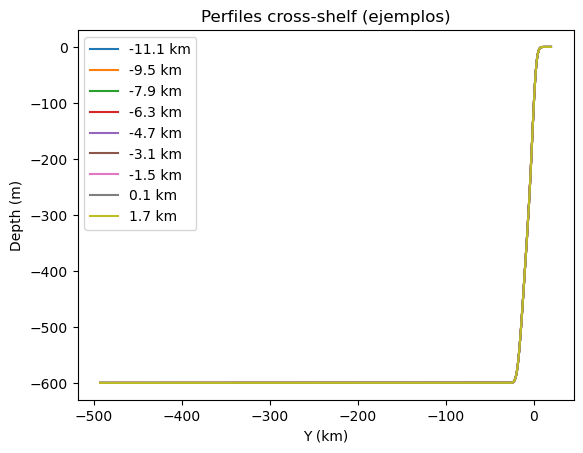

dx (muestra): [22600. 22200. 21800. 21400. 21000. 20600. 20200. 19800. 19400. 19000.] ...
dy (muestra): [18200. 17800. 17400. 17000. 16600. 16200. 15800. 15400. 15000. 14600.] ...
Archivos guardados:
  bahia_01_noShelf_bat.bin
  bahia_01_noShelf_dx.bin
  bahia_01_noShelf_dy.bin


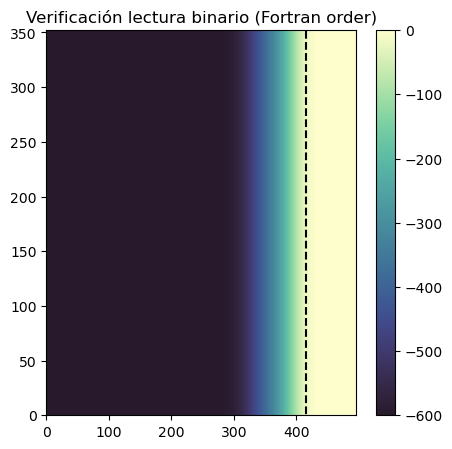

Finalizó la generación de archivos binarios para MITgcm.


In [15]:
mainbin_noshelf()